In [2]:
from pymongo import MongoClient
from elasticsearch import Elasticsearch, helpers
import requests
from IPython.display import JSON
import numpy as np
from fuzzywuzzy import fuzz
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import math
from thefuzz import fuzz, process
import re
from IPython.display import clear_output, display
import json
from unidecode import unidecode
from colavsim import colav_similarity, parse_doi, parse_string

In [3]:
es = Elasticsearch()

In [4]:
# open a file, where you stored the pickled data
file = open('dataset_full.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [5]:
len(data["p"])

101773

In [6]:
len(data["n"])

41596

In [7]:
data["p"][0]

{'Authors': 'Jaramillo-Ayerbe F., Berrío-Muñoz J.',
 'Title': 'Ivermectin for crusted Norwegian scabies induced by use of topical steroids',
 'Year': 1998,
 'Source title': 'Archives of Dermatology',
 'DOI': '10.1001/archderm.134.2.143'}

In [8]:
data["n"][0]

{'Authors': 'Flórez G.A.D., Mombello E.E., Voss S.',
 'Title': 'Novel technique for the calculation of eddy current losses and Lorentz forces in foil winding transformers',
 'Year': 2017,
 'Source title': 'International Journal of Applied Electromagnetics and Mechanics',
 'DOI': '10..3233/JAE-160144'}

In [25]:
scopus = []
for i in data["p"][0:3001]:
    scopus.append((i,True))
for i in data["n"][0:3000]:
    scopus.append((i,False))

In [19]:
es_index = list(es.indices.get_alias("*").keys())
es_index

/tmp/ipykernel_249009/2209254662.py:1: DeprecationWarning: Using positional arguments for APIs is deprecated and will be disabled in 8.0.0. Instead use only keyword arguments for all APIs. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es_index = list(es.indices.get_alias("*").keys())


['openalex_test']

In [11]:
def get_oa_doi(es_reg):
    for i in es_reg["_source"]['external_ids']:
        if i['source'] == "doi":
            return i["id"]


def get_oa_doi(es_reg):
    return es_reg["_source"]['doi']


In [12]:
def search(Title, Authors, Source, Year, punto_de_corte = 0):
    """
    Definir el valor mínimo del _score que deseas
    Puedes ajustar este valor según tus necesidades

    """
    if not isinstance(Title, str):
        Title = ""
    if not isinstance(Source, str):
        Source = ""
        
        
    body = {
        "query": {
            "bool": {
                # "must": [
                #     { "match": { "title": { "query": Title, "boost": 4 }}},
                #     { "match": { "authorships.author.display_name":  { "query": Authors, "boost": 3 } }},
                #     { "match": { "host_venue.display_name":  { "query": Source, "boost": 2 }}},
                #     { "match": { "publication_year": Year }}
                # ],
                "must": [
                    { "match": { "title": Title }},
                    { "match": { "authorships.author.display_name":  Authors }},
                    { "match": { "host_venue.display_name":  Source}},
                    { "match": { "publication_year": Year }}
                ],
                # "should": [
                #     { "match": { "title": Title }},
                #     { "match": { "authorships.author.display_name":  Authors }},
                #     { "match": { "host_venue.display_name":  Source}},
                #     { "match": { "publication_year": Year }}
                # ]
                
            }
        },
        "size": 10,
        "min_score":punto_de_corte
    }
    
    res = es.search(index=es_index, **body)
    hits = []
    
    # for i in res["hits"]["hits"]:
    #     if i["_score"] >= punto_de_corte:
    #         hits.append(i)
    # res["hits"]["hits"] = hits
    return  res

In [13]:
def parse_string(string:str):
    data = str(string).lower()
    data = re.sub(r'<[^>]+>','',data)
    data = unidecode(data)
    return data    
print(scopus[0][0]["Title"])
def parse_doi(doi):
    
    return re.sub(r'https*\:\/\/[\w\.]+\/','',str(doi).lower())

Ivermectin for crusted Norwegian scabies induced by use of topical steroids


In [14]:
parse_string(scopus[0][0]["Title"])

'ivermectin for crusted norwegian scabies induced by use of topical steroids'

In [26]:
%%time

def es_similarity(rec,th = 0):
    res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],th)
    if res["hits"]["total"]["value"] != 0:
        oa_doi = get_oa_doi(res["hits"]["hits"][0])
        sc_doi = rec["DOI"].lower()
        if parse_doi(oa_doi) == parse_doi(sc_doi):
            return True
        else:
            return False 
np.random.shuffle(scopus) #shuffle is inplace
th=0
#results=[]
#for rec in scopus[0:1000]:
#    results.append(es_similarity(rec[0],th))
results = Parallel(n_jobs=20,backend='threading',verbose=2)(delayed(es_similarity)(rec[0],th) for rec in scopus)


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:    1.7s
[Parallel(n_jobs=20)]: Done 325 tasks      | elapsed:    8.8s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:   18.8s
[Parallel(n_jobs=20)]: Done 973 tasks      | elapsed:   29.5s
[Parallel(n_jobs=20)]: Done 1418 tasks      | elapsed:   40.9s
[Parallel(n_jobs=20)]: Done 1945 tasks      | elapsed:   53.8s
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 3241 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done 4861 tasks      | elapsed:  2.2min
[Parallel(n_jobs=20)]: Done 5792 tasks      | elapsed:  2.7min


CPU times: user 2min 28s, sys: 13 s, total: 2min 41s
Wall time: 2min 47s


[Parallel(n_jobs=20)]: Done 6001 out of 6001 | elapsed:  2.8min finished


In [21]:
#>tp, tn, fp, fn
actual = []
predicted = []
for i in range(len(results)):
    if results[i] is not None:
        actual.append(scopus[i][1])
        predicted.append(results[i])


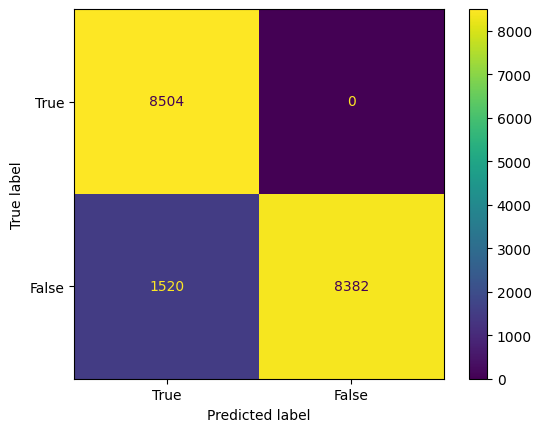

In [22]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [393]:
confusion_matrix[1][0]*100/confusion_matrix[1][1]

12.933394160583942

In [392]:
acc = metrics.accuracy_score(actual,predicted)
pre = metrics.precision_score(actual,predicted)
rec = metrics.recall_score(actual,predicted)
f1  = metrics.f1_score(actual,predicted)

print(f"Accuracy  = {acc:.4f}")
print(f"Precision = {pre:.4f}")
print(f"Recall    = {rec:.4f}")
print(f"F1        = {f1:.4f}")


Accuracy  = 0.8603
Precision = 0.8592
Recall    = 0.8855
F1        = 0.8721


In [228]:
rec = scopus[4][0]
print(rec["Title"])
print(rec["DOI"])
print(rec["Year"])
print(rec['Source title'])

res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],00)
JSON(res)

General functional response and recruitment in a predator-prey system with capture on both species
10.1002/mma.3271
2015
Mathematical Methods in the Applied Sciences


<IPython.core.display.JSON object>

In [155]:
campos_busqueda = ['campo1', 'campo2', 'campo3']
terminos_busqueda = ['término1', 'término2', 'término3']

# Construye la consulta bool con diferentes pesos
consulta_bool = {
    "bool": {
        "should": []
    }
}

for indice, campo in enumerate(campos_busqueda):
    for termino in terminos_busqueda:
        if indice == 0:
            consulta_bool["bool"]["should"].append({
                "function_score": {
                    "query": {
                        "match": {campo: termino}
                    },
                    "functions": [{
                        "field_value_factor": {
                            "field": campo,
                            "factor": 2.0  # Peso mayor para el primer campo
                        }
                    }]
                }
            })
        else:
            consulta_bool["bool"]["should"].append({
                "match": {campo: termino}
            })

# Crea la consulta de búsqueda
consulta = {
    "query": consulta_bool
}

In [177]:
JSON(consulta)

<IPython.core.display.JSON object>

In [ ]:
        # if res["hits"]["hits"][0]["_score"] > 180:
        #     return True
        # if res["hits"]["hits"][0]["_score"] < 20:
        #     return False

        # return colav_similarity(rec['Title']       ,res["hits"]["hits"][0]["_source"]['title'],
        #                         rec['Source title'],res["hits"]["hits"][0]["_source"]["host_venue"]["display_name"],
        #                         rec['Year']        ,res["hits"]["hits"][0]["_source"]['publication_year'],
        #                         ratio_thold=95, partial_thold=95,low_thold=95)
                    

    # filtered_hits = []
    # for i in res["hits"]["hits"]:
    #     if i["_score"] >= th:
    #         filtered_hits.append(i)
    # if len(filtered_hits)==0:
    #     return False
    # else:
    #     for i in res["hits"]["hits"]:
    #         if i["_score"] >= 80:
    #             filtered_hits.append(i)
    #     if len(filtered_hits)==0:
    #         return False
    #     else:
    #         return True
        
    # if res["hits"]["total"]["value"] != 0:
    #     # for i in range(len(res["hits"]["hits"])):
    #     #     if colav_similarity(parse_string(rec['Title'])       ,parse_string(res["hits"]["hits"][i]["_source"]['title']),
    #     #                             rec['Source title'],res["hits"]["hits"][i]["_source"]["host_venue"]["display_name"],
    #     #                             rec['Year']        ,res["hits"]["hits"][i]["_source"]['publication_year']):
    #     #         return True
    #     # return False
    #     res = search(rec['Title'],rec['Authors'],rec['Source title'],rec['Year'],0) #looking for positives without th
    #     if res["hits"]["total"]["value"] != 0:
    #         oa_doi = get_oa_doi(res["hits"]["hits"][0]).replace("https://doi.org/","").lower()
    #         sc_doi = rec["DOI"].lower()
    #         if oa_doi == sc_doi:
    #             return True
    #         else:
    #             return False              
    # else:
    #     return False
    # for i in res["hits"]["hits"]:
    #     # if colav_similarity(parse_string(rec['Title'])       ,parse_string(res["hits"]["hits"][0]["_source"]['title']),
    #     #                         rec['Source title'],res["hits"]["hits"][0]["_source"]["host_venue"]["display_name"],
    #     #                         rec['Year']        ,res["hits"]["hits"][0]["_source"]['publication_year']):
    #     #     return True
    #     if int(rec['Year']) == int(res["hits"]["hits"][0]["_source"]['publication_year']) and fuzz.partial_ratio(unidecode(rec['Source title'].lower()),unidecode(res["hits"]["hits"][0]["_source"]["host_venue"]["display_name"].lower()))>90:
    #         return True
            
    # return False


In [29]:
a=[1,2,3,4,"a","sfd","flksdjf"]
a

[1, 2, 3, 4, 'a', 'sfd', 'flksdjf']

In [30]:
a.remove("sfd")
a

[1, 2, 3, 4, 'a', 'flksdjf']